# Dataset Preparation

## CASIA-FASD Dataset ([Kaggle](https://www.kaggle.com/datasets/minhnh2107/casiafasd))

In [2]:
!pip install kaggle --q

In [3]:
!kaggle datasets download -d minhnh2107/casiafasd
# https://www.kaggle.com/datasets/minhnh2107/casiafasd

Dataset URL: https://www.kaggle.com/datasets/minhnh2107/casiafasd
License(s): unknown
 81% 57.0M/70.6M [00:01<00:00, 43.7MB/s]
100% 70.6M/70.6M [00:01<00:00, 45.3MB/s]


In [4]:
!unzip casiafasd.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test_img/depth/18_HR_4.avi_250_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_25_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_50_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_75_fake.jpg  
  inflating: test_img/test_img/depth/19_1.avi_25_real.jpg  
  inflating: test_img/test_img/depth/19_1.avi_50_real.jpg  
  inflating: test_img/test_img/depth/19_1.avi_75_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_100_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_125_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_150_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_175_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_200_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_25_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_50_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_75_real.jpg  
  inflating: test_img/test_img/

## Cropping the faces

In [5]:
!pip install mtcnn --q
!pip install pillow --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.7 MB/s eta 0:00:00


In [6]:
from mtcnn import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
def load_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

image_paths = load_image_paths('/content/train_img/train_img/color')

In [10]:
image_paths

['/content/train_img/train_img/color/14_HR_2.avi_225_fake.jpg',
 '/content/train_img/train_img/color/10_1.avi_75_real.jpg',
 '/content/train_img/train_img/color/11_HR_4.avi_125_fake.jpg',
 '/content/train_img/train_img/color/7_6.avi_25_fake.jpg',
 '/content/train_img/train_img/color/17_HR_1.avi_50_real.jpg',
 '/content/train_img/train_img/color/19_HR_1.avi_50_real.jpg',
 '/content/train_img/train_img/color/16_HR_4.avi_100_fake.jpg',
 '/content/train_img/train_img/color/6_7.avi_250_fake.jpg',
 '/content/train_img/train_img/color/15_2.avi_50_real.jpg',
 '/content/train_img/train_img/color/12_7.avi_175_fake.jpg',
 '/content/train_img/train_img/color/16_HR_2.avi_175_fake.jpg',
 '/content/train_img/train_img/color/3_HR_2.avi_50_fake.jpg',
 '/content/train_img/train_img/color/1_8.avi_200_fake.jpg',
 '/content/train_img/train_img/color/11_HR_2.avi_200_fake.jpg',
 '/content/train_img/train_img/color/7_7.avi_25_fake.jpg',
 '/content/train_img/train_img/color/8_HR_1.avi_125_real.jpg',
 '/content

In [12]:
def detect_and_crop_faces(image_path, detector):
    image = Image.open(image_path)
    image_np = np.asarray(image)
    result = detector.detect_faces(image_np)
    if result:
        for person in result:
            bounding_box = person['box']
            keypoints = person['keypoints']

            # Crop the detected face
            x, y, width, height = bounding_box
            cropped_face = image_np[y:y+height, x:x+width]

            # Convert the cropped face back to an image
            cropped_face_image = Image.fromarray(cropped_face)

            return cropped_face_image
    return None

# Initialize the MTCNN face detector
detector = MTCNN()

# Process each image
cropped_faces = []
for image_path in image_paths[:10]:
    cropped_face = detect_and_crop_faces(image_path, detector)
    if cropped_face:
        cropped_faces.append(cropped_face)

1/1 [==============================] - 0s 197ms/step


1/1 [==============================] - 0s 28ms/step


In [13]:
cropped_faces

[<PIL.Image.Image image mode=RGB size=149x205>,
 <PIL.Image.Image image mode=RGB size=150x185>,
 <PIL.Image.Image image mode=RGB size=138x187>,
 <PIL.Image.Image image mode=RGB size=150x198>,
 <PIL.Image.Image image mode=RGB size=168x219>,
 <PIL.Image.Image image mode=RGB size=167x211>,
 <PIL.Image.Image image mode=RGB size=160x212>,
 <PIL.Image.Image image mode=RGB size=162x223>,
 <PIL.Image.Image image mode=RGB size=165x207>,
 <PIL.Image.Image image mode=RGB size=155x199>]

In [14]:
output_dir = '/content/cropped_faces/train_img/color'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, cropped_face in enumerate(cropped_faces):
    cropped_face.save(os.path.join(output_dir, f'cropped_face_{i}.jpg'))

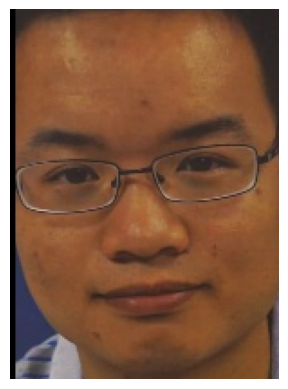

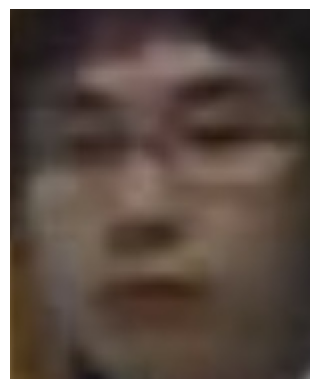

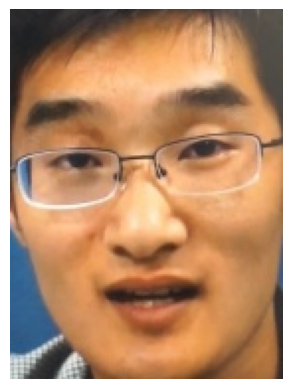

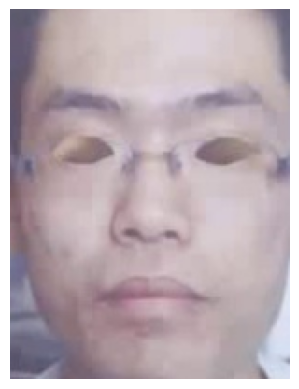

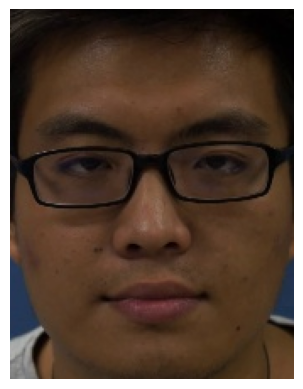

In [15]:
# Display a few cropped faces
for cropped_face in cropped_faces[:5]:
    plt.imshow(cropped_face)
    plt.axis('off')
    plt.show()